In [29]:
import pandas as pd

#Importing database
df = pd.read_csv(r"C:\Users\felip\OneDrive\Área de Trabalho\Projetos\Azure\dbo_sales_products_clients.csv", sep = ';')

# Substitute the ',' for '.'
df['gross_income'] = df['gross_income'].str.replace(',', '.')

# Converting to float
df['gross_income'] = df['gross_income'].astype(float)

#Aggregating the columns
df_agg = df.groupby('clients_id').agg({
    'gross_income': 'sum',
    'quantity': 'sum',
    'product_line': 'nunique',
    'brand': 'nunique',
    'rating': 'mean',
    'age': 'mean'
}).reset_index()

In [ ]:
from sklearn.preprocessing import StandardScaler

#Here we are normalizing the data, to avoid that bigger scales between the values
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_agg.iloc[:, 1:])

<function matplotlib.pyplot.show(close=None, block=None)>

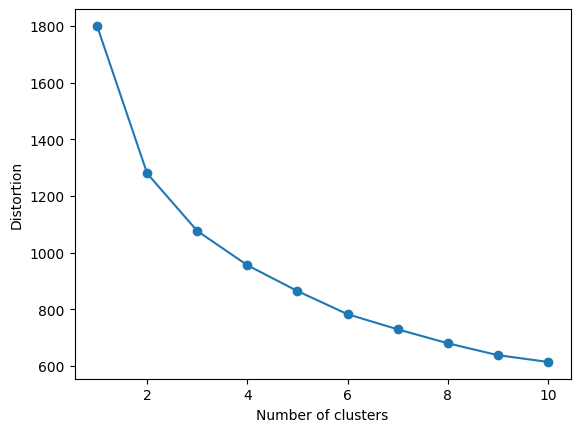

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Using Elbow method to define the number of clusters
distortions = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show

In [34]:
#Applying the KMeans
kmeans = KMeans(n_clusters = 3, random_state=42)
df_agg['clusters'] = kmeans.fit_predict(df_scaled)

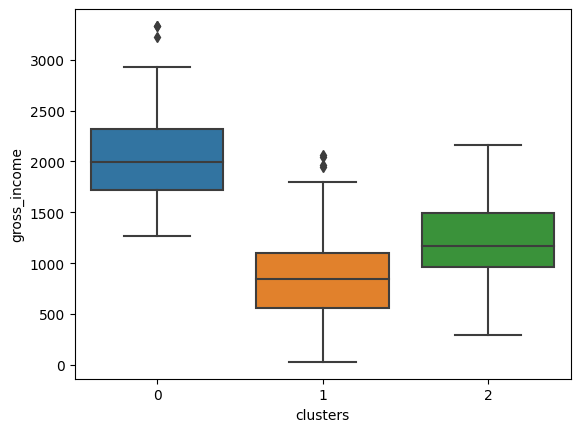

In [43]:
import seaborn as sns

sns.boxplot(x='clusters', y = 'gross_income', data = df_agg)
plt.show()

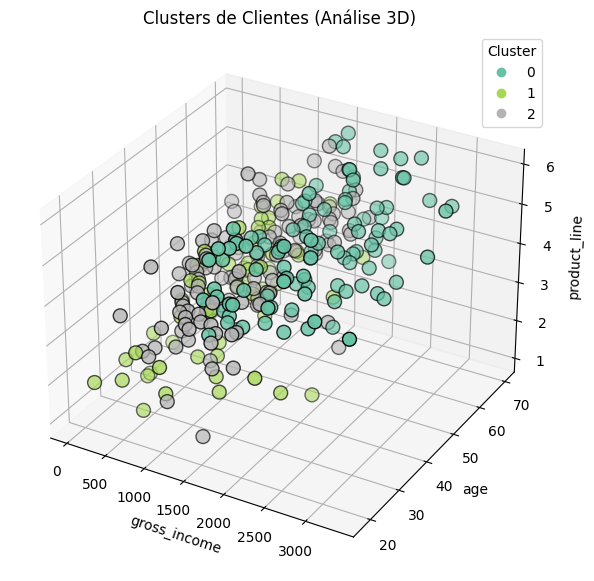

In [49]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Escolha 3 variáveis para análise
x = 'gross_income'
y = 'age'
z = 'product_line'

# Criação do gráfico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotando os pontos
scatter = ax.scatter(df_agg[x], df_agg[y], df_agg[z], c=df_agg['clusters'], cmap='Set2', s=100, edgecolor='black')

# Adicionando título e rótulos
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.set_title('Clusters de Clientes (Análise 3D)')

# Adicionando a legenda
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


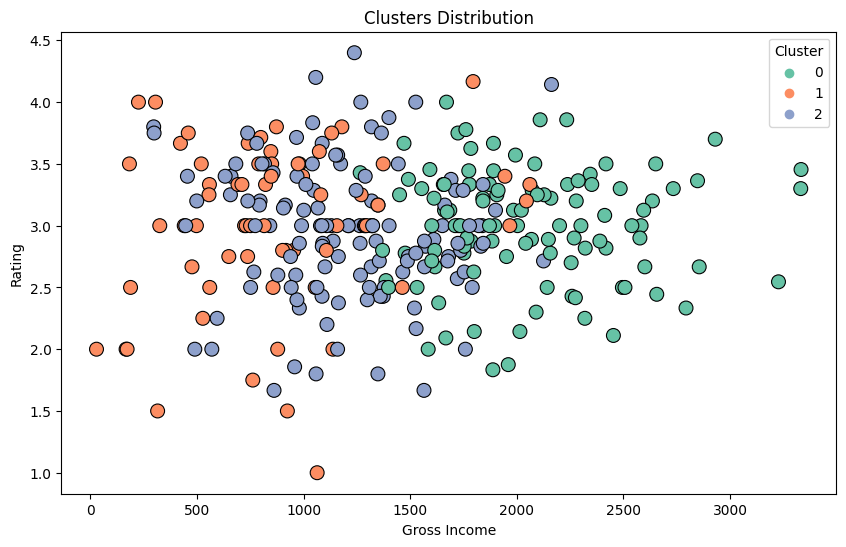

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agg, x='gross_income', y='rating', hue='clusters', palette='Set2', s=100, edgecolor='black')
plt.title('Clusters Distribution')
plt.xlabel('Gross Income')
plt.ylabel('Rating')
plt.legend(title='Cluster')
plt.show()